In [1]:
import os
import h5py
import tqdm
from matplotlib import pyplot
import numpy as np
from importlib import reload
import torch
import pickle
import cv2
from PIL import Image
from scipy.spatial.transform import Rotation
import copy
import itertools
import functools
import tqdm
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from typing import Union, Tuple, Any, Dict, List
from copy import copy
import torchvision.transforms
import ipywidgets as widgets
from IPython.display import display, HTML
from collections import defaultdict
import multiprocessing
from torch.utils.data import Subset

In [2]:
from trackertraincode import utils
from trackertraincode import vis
from trackertraincode import vis3d
from trackertraincode.neuralnets import torchquaternion
from trackertraincode.neuralnets.affine2d import Affine2d
from trackertraincode.neuralnets.modelcomponents import DeformableHeadKeypoints, rigid_transformation_25d
from trackertraincode.datasets.dshdf5pose import Hdf5PoseDataset
import trackertraincode.datatransformation as dtr
import trackertraincode.datatransformation.tensors.affinetrafo as dtraffine
from trackertraincode.datasets.batch import Batch

from trackertraincode.neuralnets.modelcomponents import GaussianMixture
# https://github.com/rfeinman/pytorch-minimize
import torchmin

/opt/conda-env/paper/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [3]:
from trackertraincode.facemodel.keypoints68 import (
    chin_left, chin_right, 
    eyecorners_left, eyecorners_right, 
    eye_left_bottom, eye_right_bottom, 
    eye_left_top, eye_right_top, 
    brows_left, brows_right, 
    nose_left, nose_right,
    uppermouth_left, uppermouth_right,
    lowermouth_left, lowermouth_right)

face_left = chin_left + eyecorners_left + eye_left_top + eye_left_bottom + uppermouth_left + lowermouth_left + brows_left + nose_left
face_right = chin_right + eyecorners_right + eye_right_top + eye_right_bottom + uppermouth_right + lowermouth_right + brows_right + nose_right

In [4]:
%matplotlib ipympl

In [5]:
filename = os.path.join(os.environ['DATADIR'],'lapa-megaface-v3.h5')

interactive(children=(IntSlider(value=10, description='idx', max=20), Output()), _dom_classes=('widget-interac…

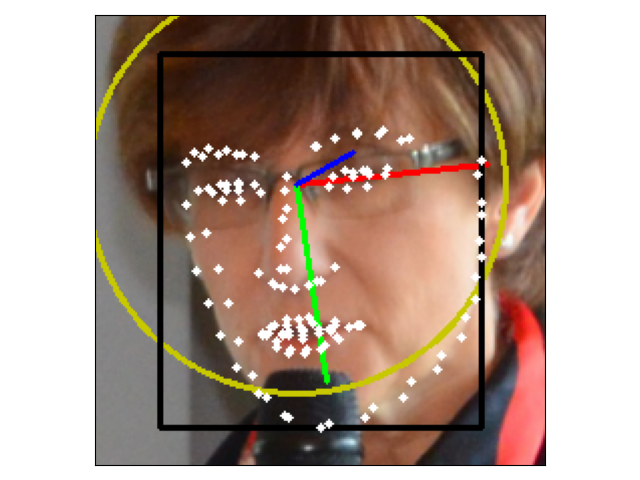

In [6]:
tr = torchvision.transforms.Compose([
    dtr.batch.FocusRoi(224, extent_factor=1.2, insert_backtransform=True),
    dtr.batch.normalize_batch
])
ds = Hdf5PoseDataset(filename, monochrome=False, transform=tr, whitelist=['/images','/rois','/pt2d_68','/pseudolabels/*'])

fig, ax = pyplot.subplots(1,1)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
pyplot.tight_layout()

@widgets.interact(idx=(0,20))
def plot_image(idx):
    smpl = ds[idx]
    smpl = dtr.batch.to_numpy(dtr.batch.unnormalize_batch(smpl))
    img = vis.draw_dataset_sample(smpl)
    ax.clear()
    ax.imshow(img)
    pyplot.draw()

In [7]:
class PosedDeformableHead(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.deformablekeypoints = DeformableHeadKeypoints()

    def forward(self, quats, coords, params):
        local_keypts = self.deformablekeypoints.forward(params)
        pt3d_68 = rigid_transformation_25d(
            quats,
            coords[...,:2],
            coords[...,2:],
            local_keypts)
        assert pt3d_68.shape[-1] == 3 and pt3d_68.shape[-2] == 68
        return pt3d_68


class DeformableHeadFitting:
    def __init__(self, fit_3d_projections):
        self.fit_3d_projections = fit_3d_projections
        self.headmodel = PosedDeformableHead()
        self.shapemodel = GaussianMixture.from_hdf5('../trackertraincode/facemodel/shapeparams_gmm.h5')
    
    def _extract_params(self, params):
        quats = params[...,:4]
        quats = quats / torch.linalg.norm(quats,dim=-1,keepdim=True)
        coords = params[...,4:4+3]
        shapeparams = params[...,4+3:]
        return quats, coords, shapeparams

    def evalheadmodel(self, params):
        quats, coords, shapeparams = self._extract_params(params)
        points = self.headmodel(quats, coords, shapeparams)
        return points

    def _rotation_similarity_to_nn_prediction(self,xvec):
        quats = xvec[...,:4]
        quats = quats / torch.linalg.norm(quats,dim=-1,keepdim=True)
        initial_quat = self.x0[...,:4]
        return torchquaternion.distance(quats, initial_quat)
    
    def lossfunc(self, xvec, yvec, pointweights):
        points = self.evalheadmodel(xvec)
        errs = (pointweights[...,None]*torch.nn.functional.smooth_l1_loss(points[...,:2], yvec, beta=0.1, reduction='none')).mean(axis=(-2,-1))
        norm_constraint = torch.square(1. - torch.linalg.norm(xvec[...,:4]))
        shape_plausibility = -(1./150.)*self.shapemodel(xvec[...,-50:])
        size_constraint = 10.*torch.exp(-xvec[6]/0.05)
        rot_similarity = self._rotation_similarity_to_nn_prediction(xvec)
        return errs + 1.e-6*norm_constraint + 0.01*shape_plausibility + size_constraint + 0.1*rot_similarity
    
    def _make_initial_guess(self, smpl):
        xvec = torch.concat([torchquaternion.normalized(smpl['pose']), smpl['coord'], torch.zeros((50,))])
        return xvec
    
    def _make_target_points_and_weights(self, smpl : Batch):
        pointweights = torch.ones((68,))
 
        if not self.fit_3d_projections:
            pointweights[chin_left] = torch.linspace(0.01,0.1,9) #0.01 #0.1
            pointweights[chin_right] = torch.flip(torch.linspace(0.01,0.1,9),dims=(0,)) #0.01 #0.1

        angle_cutoff_for_fitting_jaw = 15. * np.pi/180.
        angle_cutoff_for_fitting_face_side = 70. * np.pi/180.
        
        h,_,_ = utils.as_hpb(Rotation.from_quat(smpl['pose']))
        backside_weight_jaw = max(0., float(1. - np.abs(h)/angle_cutoff_for_fitting_jaw))
        backside_weight_face_side = max(0.1, float(1. - np.abs(h)/angle_cutoff_for_fitting_face_side))

        if not self.fit_3d_projections:
            if h < 0:
                pointweights[face_right] = backside_weight_face_side
                pointweights[chin_right] = backside_weight_jaw
            elif h > 0:
                pointweights[face_left] = backside_weight_face_side
                pointweights[chin_left] = backside_weight_jaw
               
        if self.fit_3d_projections:
            targets = smpl['pt3d_68'][...,:2]
        else:
            targets = smpl['pt2d_68'][...]
 
        return targets, pointweights
        
    
    def fit(self, smpl : Batch):
        quat = smpl['pose']

        ytarget, pointweights = self._make_target_points_and_weights(smpl)
            
        self.x0 = x0 = self._make_initial_guess(smpl)

        def lossfunc_wo_shape(x):
            return self.lossfunc(torch.concat([x,x0[...,7:]],axis=-1), ytarget, pointweights)
        
        def actual_lossfunc(x):
            return self.lossfunc(x, ytarget, pointweights)
        
        ret = torchmin.minimize(lossfunc_wo_shape, x0[...,:7], method='bfgs', max_iter=50)

        x0 = torch.concat([ret['x'],x0[...,7:]],axis=-1)
        
        ret = torchmin.minimize(actual_lossfunc, x0, method='bfgs', max_iter=100, tol=0.0005)

        if not ret['success']:
            print (f"fit failure at index {smpl['index']} because {ret['message']}")

        bestfitparams = ret['x']
        fitted_points = self.evalheadmodel(bestfitparams)
        quats, coords, shapeparams = self._extract_params(bestfitparams.cpu())
        pred = Batch(smpl.meta, {
            'pt3d_68' : fitted_points.cpu().numpy(),
            'pose' : quats.numpy(),
            'coord' : coords.numpy(),
            'shapeparam' : shapeparams.numpy(),
            'index' : smpl['index'].numpy(),
            'image_backtransform' : smpl['image_backtransform'].numpy(),
        })

        return pred

headmodel = DeformableHeadFitting(False)
headmodel.fit(ds[2])

Batch()

In [8]:
#fitds = Subset(ds, list(range(40)))
fitds = ds

preds = [ headmodel.fit(smpl) for smpl in tqdm.tqdm(fitds) ]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.33it/s]


In [9]:
back_transformed = []
for pred in preds:
    pred = dtr.batch.to_tensor(pred)
    backtrafo = Affine2d(pred['image_backtransform'])
    back_pred = {}
    back_pred['pose'] = dtraffine.transform_rot(backtrafo, pred['pose'])
    back_pred['coord'] = dtraffine.transform_coord(backtrafo, pred['coord'])
    back_pred['pt3d_68'] = dtraffine.transform_points(backtrafo, pred['pt3d_68'])
    back_pred['shapeparam'] = pred['shapeparam']
    back_transformed.append(back_pred)

In [10]:
zipped_preds = defaultdict(list)
for pred in back_transformed:
    for k,v in pred.items():
        zipped_preds[k].append(v)
for k, v in zipped_preds.items():
    zipped_preds[k] = np.stack(v, axis=0)

In [11]:
facerender = vis3d.FaceRender()

In [12]:
keypointmodel = PosedDeformableHead()

interactive(children=(IntSlider(value=19, description='idx', max=39), Output()), _dom_classes=('widget-interac…

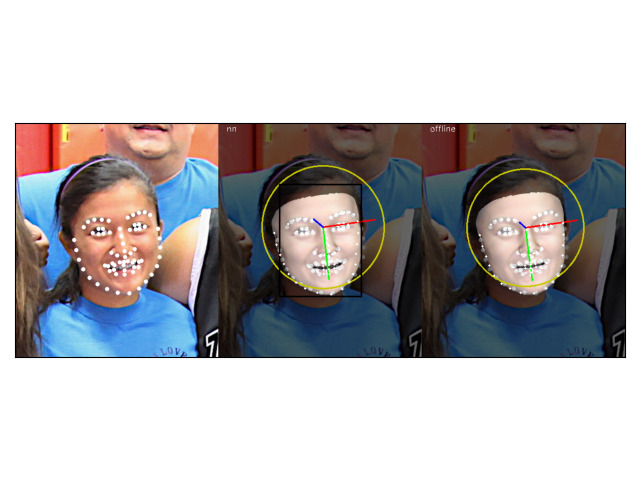

In [13]:
fig, ax = pyplot.subplots(1,1)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
pyplot.tight_layout()

dsplot = Hdf5PoseDataset(filename, monochrome=False, whitelist=['/images','/rois','/pt2d_68','/pseudolabels/*'])


def _visualize(sample):
    img = sample['image']
    rendering = facerender.set(
        sample['coord'][:2],
        sample['coord'][2],
        Rotation.from_quat(sample['pose']),
        sample['shapeparam'][:50],
        img.shape[:2],
    )
    sample = copy(sample)
    rendering = Image.fromarray(rendering)
    img = Image.fromarray(img)
    img = Image.blend(rendering, img, 0.4)
    sample['image'] = np.asarray(img)
    img = vis.draw_dataset_sample(sample)
    return img


@widgets.interact(idx=(0,len(fitds)-1))
def plot_image(idx):
    nn_sample = copy(dsplot[idx])
    offline_sample = copy(back_transformed[idx])
    ktps2d = nn_sample['pt2d_68']
    del nn_sample['pt2d_68']
    
    with torch.no_grad():
        kpts = keypointmodel(offline_sample['pose'], offline_sample['coord'], offline_sample['shapeparam'])

    offline_sample = dtr.to_numpy(offline_sample)
    nn_sample = dtr.to_numpy(nn_sample)

    img = offline_sample['image'] = nn_sample['image']

    vis.draw_points3d(
        img,
        ktps2d.numpy(),
        labels=False
    )
    nn_vis = _visualize(nn_sample)
    nn_vis = cv2.putText(nn_vis, 'nn', (15,15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255))
    offline_vis = _visualize(offline_sample)
    offline_vis = cv2.putText(offline_vis, 'offline', (15,15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255))
    img = np.r_['1,1,1',img,nn_vis,offline_vis]
    
    ax.clear()
    ax.imshow(img)
    pyplot.draw()

In [16]:
ds.close()

In [17]:
fitds.close()

In [18]:
dsplot.close()

In [19]:
from trackertraincode.datasets.dshdf5pose import create_pose_dataset, FieldCategory

C = FieldCategory

with h5py.File(filename,'a') as f:
    #del f['2dfit_v3']
    g = f.create_group("2dfit_v3")
    ds_quats = create_pose_dataset(g, C.quat, data=zipped_preds['pose'])
    ds_coords = create_pose_dataset(g, C.xys, data=zipped_preds['coord'])
    ds_pt3d_68 = create_pose_dataset(g, C.points, name='pt3d_68', data=zipped_preds['pt3d_68'])
    ds_shapeparams = create_pose_dataset(g, C.general, name='shapeparams', dtype=np.float16, data=zipped_preds['shapeparam'])